In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from statsmodels.tsa.arima.model import ARIMA
# hide warnings
import warnings
warnings.simplefilter("ignore")

# checking if plotly is installed; install otherwise
try:
    import chart_studio.plotly as py
except:
    ! pip install --user plotly
    import chart_studio.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# checking if seaborn is installed; install otherwise
try:
    import seaborn as sns
except:
    ! pip install --user seaborn
    import seaborn as sns

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [8]:
# read the csv file into a DataFrame
df = pd.read_csv("E:\\Python Projects\\Mounica\\GlobalLandTemperaturesByMajorCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

# dropping AverageTemperatureUncertainty, Latitude and Longitude and combining City and Country into City
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

# removing all rows with NaN values
df = df.dropna()

# get list of all cities in dataset
cities = set(df.City)

In [9]:
# check stationarity in time series data of a given city

def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    city_df.plot(figsize=(10, 10))
    
    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [10]:
# check stationarity for data of a specific city entered by the user

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=71, options=("Abidjan, Côte D'Ivoire", 'Addis Abeba, Ethiopia', 'Ahmadabad…

In [11]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for New York, United States


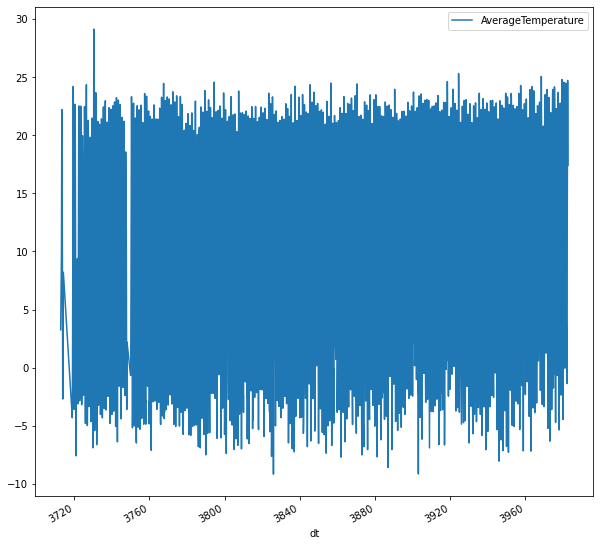

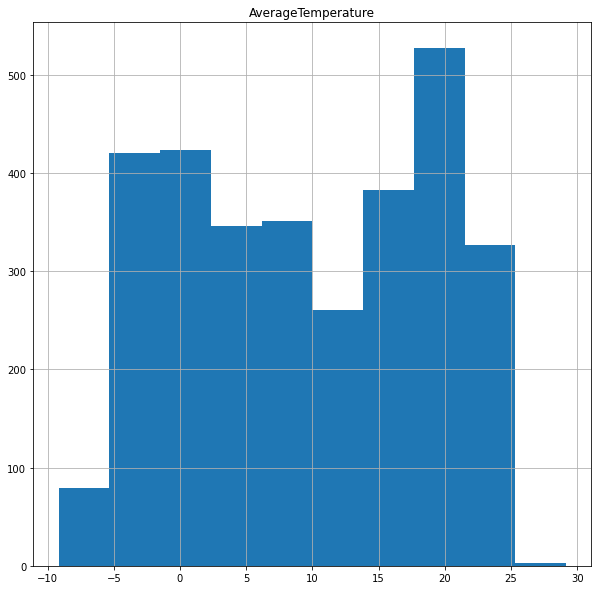

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [12]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

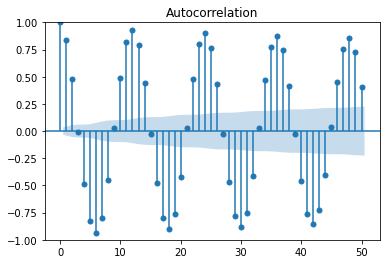

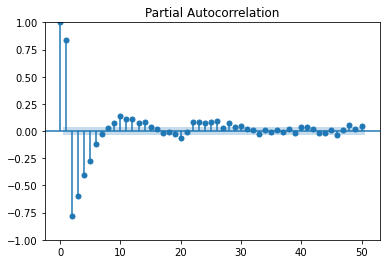

In [13]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [74]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
# To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        pq_values.append((p, q))
        model = ARIMA(city_df, order=(p, d, q))
        results = model.fit()
        print(p,d,q)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
        pq_values.append((p, q))

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

0 0 0
0 0 1
0 0 2
1 0 0
1 0 1
1 0 2
2 0 0
2 0 1
2 0 2
(p,q) corresponding to lowest AIC score:  (1, 1)


In [75]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 17.1673022115749
Mean Absolute Error: 3.407576139328169


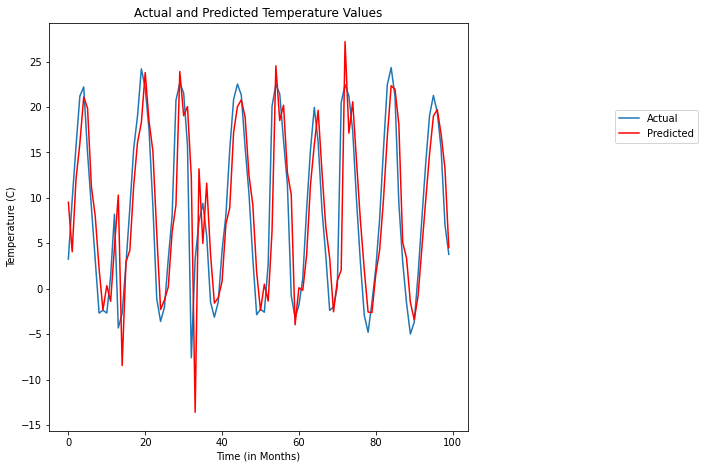

In [76]:
# comparing first 100 predictions with actual values

plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [77]:
# drop-down menu to select number of years for which predictions are required

years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [79]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

In [81]:
arima_model.forecast(steps=number_of_steps)

3119    15.671589
3120    14.264086
3121    13.178792
3122    12.341947
3123    11.696675
          ...    
3237     9.523218
3238     9.523218
3239     9.523218
3240     9.523218
3241     9.523218
Name: predicted_mean, Length: 123, dtype: float64

In [82]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)  # predictions

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  # excluding predictions for remaining months in current year

In [83]:
# displaying forecasted values for the nth year

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  9.523218462685254 C
February:  9.523218462684842 C
March:  9.523218462684522 C
April:  9.523218462684277 C
May:  9.523218462684087 C
June:  9.523218462683941 C
July:  9.523218462683829 C
August:  9.523218462683742 C
September:  9.523218462683674 C
October:  9.523218462683623 C
November:  9.523218462683584 C
December:  9.523218462683552 C


In [84]:
# plotting the predicted values for the nth year

trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [86]:
out_of_sample_forecast

3122    12.341947
3123    11.696675
3124    11.199121
3125    10.815468
3126    10.519642
          ...    
3237     9.523218
3238     9.523218
3239     9.523218
3240     9.523218
3241     9.523218
Name: predicted_mean, Length: 120, dtype: float64

### OBJECTIVE 1: Predicting the Temperature Change of a Given City across a Specified Time Period ###

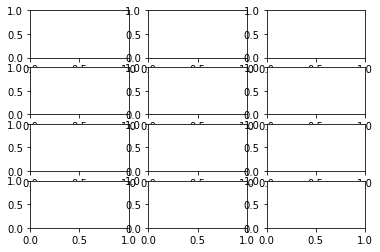

In [87]:
# plotting monthly temperature changes from 2013 to 2013+n years

fig, ax = plt.subplots(nrows=4, ncols=3)

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast]
        else:
            monthly_change[month].append(out_of_sample_forecast)
        temp+=12

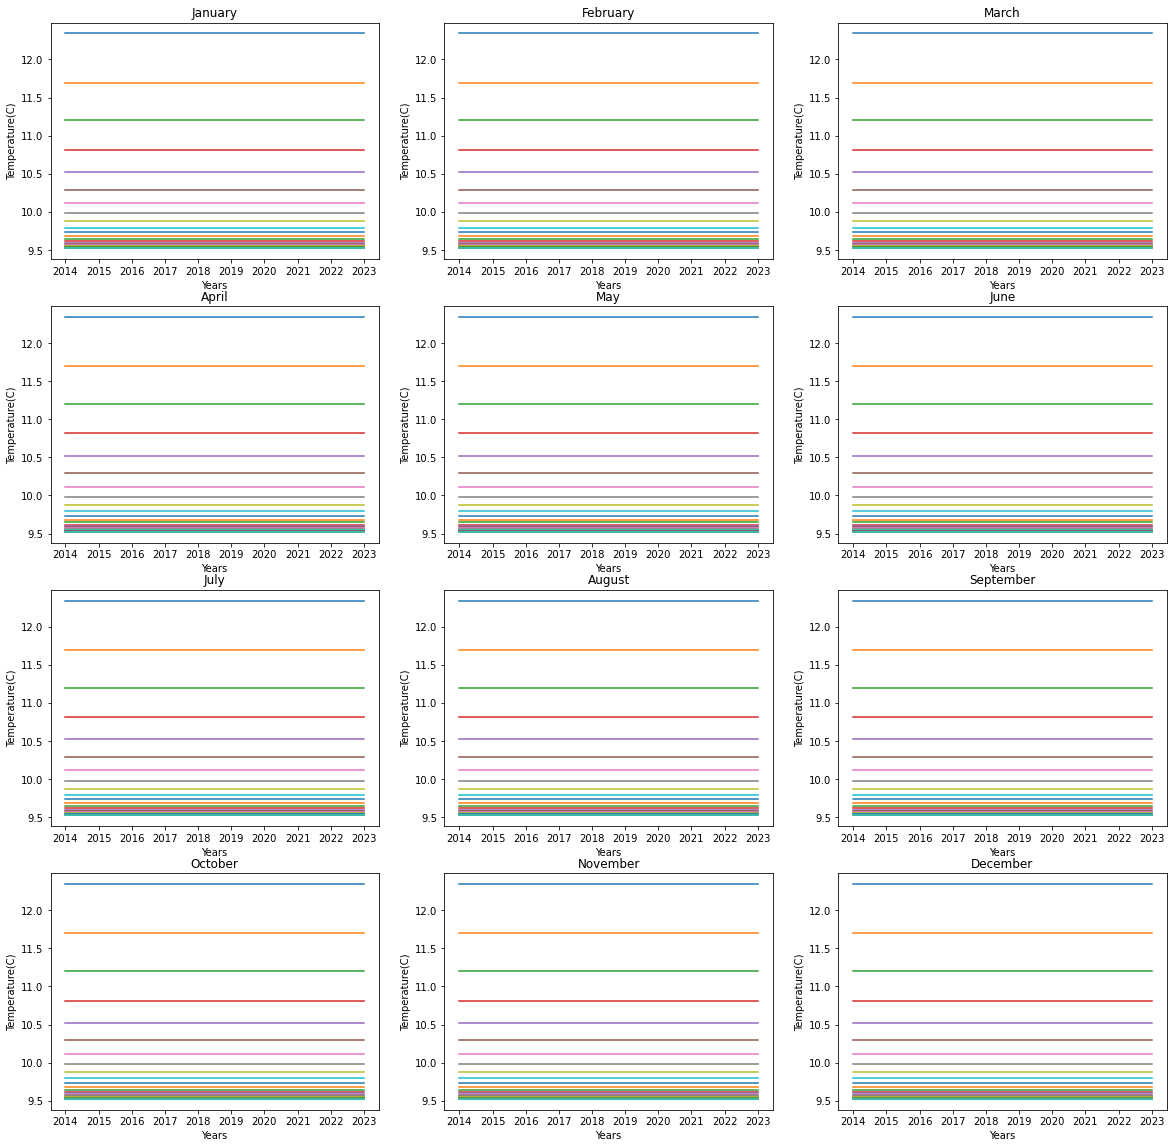

In [88]:
plt.figure(figsize=(20,20))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()

In [90]:
# read the csv file into a DataFrame
df = pd.read_csv("E:\\Python Projects\\Mounica\\GlobalLandTemperaturesByMajorCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']
df = df.drop({"AverageTemperatureUncertainty"}, 1)
df = df.dropna()

# while estimating top 10 US cities using the whole data, we got multiple cities with identical latitude and longitude values, making plotting difficult
# therefore, we only consider US cities with unique latitude and longitude values

# getting the first city for each unique latitude-Longitude pair
new_us_cities_df = df[df.Country=='United States'].drop('Country', 1)
new_us_cities_df['latlon'] = new_us_cities_df['Latitude'] + ', ' + new_us_cities_df['Longitude']
new_us_cities_df = new_us_cities_df.sort_values('latlon')
unique_latlon_values = set(list(new_us_cities_df.latlon))

cities = list(new_us_cities_df.City)

unique_latlon_first_cities = []

for x in unique_latlon_values:
    i = list(new_us_cities_df.latlon).index(x)
    unique_latlon_first_cities.append(cities[i])

part_2_df = df[df['City'].isin(unique_latlon_first_cities)].drop(['Country', 'Latitude', 'Longitude'], 1)
part_2_df.head()

,AverageTemperature,City
dt,,
1743-11-01,5.436,Chicago
1744-04-01,8.766,Chicago
1744-05-01,11.605,Chicago
1744-06-01,17.965,Chicago
1744-07-01,21.680,Chicago


In [93]:
# hide warnings
import warnings
warnings.simplefilter("ignore")

changes = []  # stores temperature change for cities
avg_2013 = []  # stores average of 2013 temperature for each city
avg_2023 = []  # stores average of 2023 temperature for each city

for each_city in set(unique_latlon_first_cities):
    new_city_df = part_2_df[part_2_df.City == each_city].drop("City", 1)  # new df for each city
    new_city_df_mean = new_city_df.resample("A").mean()  # stores yearly mean temperature values for city
    new_city_df_mean = new_city_df_mean.dropna()
    last_year_average = new_city_df_mean['AverageTemperature'][-1]  # average of last year temperature for comparison later
    avg_2013.append(last_year_average)
    
    # making predictions for city for next 10 years
    p_range = q_range = [i for i in range(0,3)]  # taking values from 0 to 2

    aic_values = []
    bic_values = []
    pq_values = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(new_city_df, order=(p, 0, q))
                results = model.fit()
                aic_values.append(results.aic)
                bic_values.append(results.bic)
                pq_values.append((p, q))
            except:
                pass
    
    best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
    
    arima_model = ARIMA(new_city_df, order=(best_pq[0], 0, best_pq[1])).fit()
    
    # make prediction for next 10 years using 120 steps
    out_of_sample_forecast = arima_model.forecast(steps=120)
    average_after_10_years = np.mean(out_of_sample_forecast[-9:])  # average of 10th year's values (after 10 years) i.e. average of last 9 values (Jan-Sep because 2013 values end at September)
    avg_2023.append(average_after_10_years)
    
    changes.append(abs(last_year_average - average_after_10_years))
    
    top_10_changes_indices = sorted(range(len(changes)), key=lambda i: changes[i], reverse=True)[:10]
    top_10_cities = [unique_latlon_first_cities[x] for x in top_10_changes_indices]
    top_10_cities

In [94]:
# plotting the top-10 cities using plotly

top10_df = pd.DataFrame()
top10_df['city'] = top_10_cities
top10_df['latitude'] = [new_us_cities_df.Latitude[new_us_cities_df.City==x][-1] for x in top_10_cities]
top10_df['longitude'] = [new_us_cities_df.Longitude[new_us_cities_df.City==x][-1] for x in top_10_cities]
top10_df['2013_average'] = [avg_2013[x] for x in top_10_changes_indices]
top10_df['2023_average'] = [avg_2023[x] for x in top_10_changes_indices]
top10_df['change'] =  [changes[x] for x in top_10_changes_indices]
top10_df = top10_df.round({'2013_average':2, '2023_average':2, 'change':2})
top10_df['text'] = top10_df['city'] + ', Avg. Temperature in 2013: ' + top10_df['2013_average'].astype(str) + 'C, Avg. Temperature in 2023: ' + top10_df['2023_average'].astype(str) +'C'

# convert latitude and longitude to numeric values for plotting i.e. remove 'N' and 'W' from values and also make longitudes negative
top10_df['latitude'] = [float(x[:-1]) for x in list(top10_df['latitude'])]
top10_df['longitude'] = [-float(x[:-1]) for x in list(top10_df['longitude'])]

### OBJECTIVE 2: Top-10 Cities in the US with Maximum Temperature Change ###

In [95]:
scl = [ [0,"rgb(172, 5, 5)"],[0.35,"rgb(190, 40, 40)"],[0.5,"rgb(245, 70, 70)"],[0.6,"rgb(245, 89, 89)"],[0.7,"rgb(247, 106, 106)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = top10_df['longitude'],
        lat = top10_df['latitude'],
        text = top10_df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = top10_df['change'],
            cmax = top10_df['change'].max(),
            colorbar=dict(
                title="Temperature Change"
            )
        ))]

layout = dict(
        title = 'Top 10 Cities with most Temperature Change in 10 Years<br><i>Hover for Details</i>',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=data, layout=layout)
iplot(fig, validate=False, filename='top-10-cities')

### OBJECTIVE 3: The Effect of Pollution and Greenhouse Gases on Temperature Change ###

In [138]:
#mask = np.zeros(edges.shape,dtype='uint8')

NameError: name 'edges' is not defined

In [114]:
# Dataframes implement the Pandas API
# import dask.dataframe as dd
# df = dd.read_csv(filename)

In [32]:
df = pd.read_csv('E:\\Python Projects\\Mounica\\pollutions_2008_2010.csv')
# new_df = df.drop(['Unnamed: 0','State Code', 'County Code', 'Site Num', 'Address',
#        'State', 'County', 'NO2 Units', 'NO2 Mean',
#        'NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units',
#        'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units',
#        'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour','CO Units', 'CO Mean','CO 1st Max Value', 'CO 1st Max Hour'],axis = 1)

new_df =df

In [33]:
new_df

,City,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
0,Phoenix,01-01-2008,50,31,4.0,NaN
1,Phoenix,01-01-2008,50,31,4.0,22.0
2,Phoenix,01-01-2008,50,31,NaN,NaN
3,Phoenix,01-01-2008,50,31,NaN,22.0
4,Phoenix,02-01-2008,36,29,1.0,NaN
...,...,...,...,...,...,...
303887,Portland,05-06-2010,26,33,3.0,NaN
303888,Portland,05-06-2010,26,33,3.0,7.0
303889,Portland,05-06-2010,26,33,NaN,NaN
303890,Portland,05-06-2010,26,33,NaN,7.0


In [34]:
new_df.describe

<bound method NDFrame.describe of             City  Date Local  NO2 AQI  O3 AQI  SO2 AQI  CO AQI
0        Phoenix  01-01-2008       50      31      4.0     NaN
1        Phoenix  01-01-2008       50      31      4.0    22.0
2        Phoenix  01-01-2008       50      31      NaN     NaN
3        Phoenix  01-01-2008       50      31      NaN    22.0
4        Phoenix  02-01-2008       36      29      1.0     NaN
...          ...         ...      ...     ...      ...     ...
303887  Portland  05-06-2010       26      33      3.0     NaN
303888  Portland  05-06-2010       26      33      3.0     7.0
303889  Portland  05-06-2010       26      33      NaN     NaN
303890  Portland  05-06-2010       26      33      NaN     7.0
303891  Portland  06-06-2010       19      18      1.0     NaN

[303892 rows x 6 columns]>

In [35]:
new_df.columns

Index(['City', 'Date Local', 'NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI'], dtype='object')

In [37]:
#Data Cleaning : 
#-----------------------------------------------------------------------------------------------------------------#

# For NO2

# Get only the NO2 AQI values and Date Local
no2_df = new_df.drop(['O3 AQI', 'SO2 AQI', 'CO AQI'],1)

# Every day has multiple values, so we will take only the maximum values of NO2 AQI every day
no2_df = no2_df.sort_values('NO2 AQI', ascending = 0).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datatime format
no2_df['Date Local'] = pd.to_datetime(no2_df['Date Local'])
no2_df.index = no2_df['Date Local']
del no2_df['Date Local']

# Consider only New York City
no2_df = no2_df[no2_df['City'] == 'New York']

# Calculate mean N02 AQI per year
no2_df = no2_df.resample("A").mean()
no2_df= no2_df.sort_index()
no2_df = no2_df.dropna()

#-----------------------------------------------------------------------------------------------------------------#

# For SO2
so2_df = new_df.drop(['O3 AQI', 'NO2 AQI', 'CO AQI'],1)
so2_df = so2_df.sort_values('SO2 AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
so2_df['Date Local'] = pd.to_datetime(so2_df['Date Local'])
so2_df.index = so2_df['Date Local']
del so2_df['Date Local']
so2_df = so2_df[so2_df['City'] == 'New York']
so2_df = so2_df.resample("A").mean()
so2_df= so2_df.sort_index()
so2_df = so2_df.dropna()
so2_df.head()

#-----------------------------------------------------------------------------------------------------------------#

# For CO
co_df = new_df.drop(['SO2 AQI', 'NO2 AQI', 'O3 AQI'],1)
co_df = co_df.sort_values('CO AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
co_df['Date Local'] = pd.to_datetime(co_df['Date Local'])
co_df.index = co_df['Date Local']
del co_df['Date Local']
co_df = co_df[co_df['City'] == 'New York']
co_df = co_df.resample("A").mean()
co_df= co_df.sort_index()
co_df = co_df.dropna()

In [40]:
# Data Cleaning for Temperature Data where we are only considering the Temperature for New York City
df = pd.read_csv("E:\\Python Projects\\Mounica\\GlobalLandTemperaturesByMajorCity.csv")
df = df[df['Country'] == 'United States']
df = df[df['City'] == 'New York']
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
df['Date Local'] = pd.to_datetime(df['dt'])
# set first column (dt) as the index column
df.index = df['Date Local']
del df['dt'],df['City'],df['Country']
df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
df = df.resample("A").mean()

df = df.dropna()
df = df.sort_index()

In [41]:
# Joining different Pollution Data with the Temperature Data

j1 = pd.merge(df, no2_df, left_index = True, right_index = True, how='inner')
j2 = pd.merge(so2_df, j1, left_index = True, right_index = True, how='inner')
j3 = pd.merge(co_df, j2, left_index = True, right_index = True, how='inner')
j3.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2008-12-31,13.750000,45.733333,10.641667,53.523810
2009-12-31,13.700000,43.594595,10.141833,55.175439
2010-12-31,10.266667,32.500000,11.357583,56.639344


In [42]:
# Normalize the data so that all the column data can be compared
j3_norm = (j3 - j3.mean()) / (j3.max() - j3.min())
j3_norm.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2008-12-31,0.338118,0.387206,-0.059246,-0.510042
2009-12-31,0.323764,0.225588,-0.470377,0.020085
2010-12-31,-0.661882,-0.612794,0.529623,0.489958


In [43]:
# Plotting the data
trace0 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['AverageTemperature'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['CO AQI'],
    mode = 'lines',
    name = 'Carbon Monoxide'
)

trace3 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['SO2 AQI'],
    mode = 'lines',
    name = 'Sulphur Dioxide'
)

trace4 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['NO2 AQI'],
    mode = 'lines',
    name = 'Nitrogen Dioxide'
)

layout = go.Layout(
    title='Temperature and Pollution Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

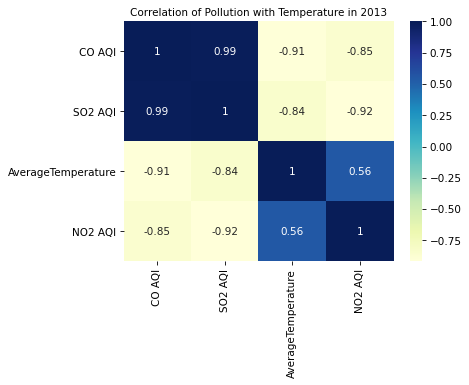

In [44]:
# Plotting the correlation matrix for Pollution vs. Temperature

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(j3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Pollution with Temperature in 2013", fontsize=10)
plt.show()

### SECTION 2: Greenhouse Gases and Temperature Change ###

In [45]:
df = pd.read_csv("E:\\Python Projects\\Mounica\\GlobalLandTemperaturesByMajorCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"}, 1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()

In [46]:
gg_df = pd.read_csv("E:\\Python Projects\\Mounica\\greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)

# getting yearly emissions for the 4 major greenhouse gases i.e. CO2, Methane, Nitrous Oxide and HCFCs
df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']

In [47]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,9.661333
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,11.322500
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.357250
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,9.572667
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,10.040917


In [48]:
# normalizing the values

part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [49]:
# Plotting values for Greenhouse Gases along with Temperature

trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)


layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

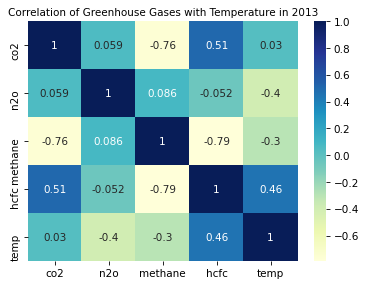

In [50]:
# Plotting the correlation matrix for the Greenhouse Gases

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2013", fontsize=10)
plt.show()

In [96]:
l = [df_usa_methane, df_usa_hcfc, df_usa_n2o, df_usa_co2]

future_values = []


# Model Summary for Greenhouse Gases
for gas in l:

    p_range = q_range = list(range(0,3))  # taking values from 0 to 2
    
    # Directly converting the index of gas dataframe changes it to become a DateTimeIndex so we converted and saved it to a temporary dataframe
    temp = pd.to_datetime(gas.index,format = '%Y')
    gas['year'] = temp
    gas.set_index('year',inplace=True)
    
    aic_values = []
    bic_values = []
    pq_values = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(gas, order=(1,1,1))
                results = model.fit()
                print(results.summary())
                #aic_values.append(results.aic)
                #bic_values.append(results.bic)
                #pq_values.append((p, q))
            except:
                pass

    # (p,q) corresponding to lowest AIC score
    #best_pq = pq_values[aic_values.index(min(aic_values))]  

    #arima_model = ARIMA(gas, order=(best_pq[0], 0, best_pq[1])).fit()
    #out_of_sample_forecast = arima_model.forecast(steps=10)[0]
   
       #for i in out_of_sample_forecast:
#         future_values.append(i)

# # Separating and storing them in different lists which will then be converted to a dataframe
# future_methane = future_values[:10]
# future_co2 = future_values[30:40]
# future_hcfc = future_values[10:20]

# # Data Frame that stores predicted Greenhouse gas values
# future_gg = pd.DataFrame({'Methane':future_methane,'CO2':future_co2,'HCFC':future_hcfc},columns = ['Methane','CO2','HCFC'])
# future_gg.head()

                               SARIMAX Results                                
Dep. Variable:                methane   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -250.527
Date:                Sat, 27 Nov 2021   AIC                            507.055
Time:                        16:12:50   BIC                            510.589
Sample:                    01-01-1990   HQIC                           507.992
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0641      8.092      0.008      0.994     -15.795      15.924
ma.L1         -0.0589      8.101     -0.007      0.994     -15.937      15.819
sigma2        5.3e+07   2.08e-06   2.55e+13      0.0

In [98]:
# Predicting future annual temperature values across the next 10 years for New York

ny_df = pd.read_csv("E:\\Python Projects\\Mounica\\GlobalLandTemperaturesByMajorCity.csv")
ny_df = ny_df[ny_df['Country'] == 'United States']
ny_df = ny_df[ny_df['City'] == 'New York']
ny_df = ny_df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
ny_df['Date Local'] = pd.to_datetime(ny_df['dt'])
# set first column (dt) as the index column
ny_df.index = ny_df['Date Local']
del ny_df['dt'], ny_df['City'], ny_df['Country']
ny_df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
ny_df = ny_df.resample("A").mean()

ny_df = ny_df.dropna()
ny_df = ny_df.sort_index()

# fitting an ARIMA model

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(gas, order=(1,1,1))
            results = model.fit()
            print(results.summary())
            #aic_values.append(ARMAResults.aic(results))
            #bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

#best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
#print("(p,q) corresponding to lowest AIC score: ", best_pq)

#arima_model = ARIMA(ny_df, order=(best_pq[0], 0, best_pq[1])).fit()

#ny_out_of_sample_forecast = arima_model.forecast(steps=10)[0]

#future_gg['Temperature'] = ny_out_of_sample_forecast

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -319.719
Date:                Sat, 27 Nov 2021   AIC                            645.437
Time:                        16:15:12   BIC                            648.972
Sample:                    01-01-1990   HQIC                           646.375
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3304      3.341     -0.099      0.921      -6.878       6.217
ma.L1          0.3190      3.421      0.093      0.926      -6.385       7.024
sigma2      1.706e+10   1.81e-09   9.43e+18      0.0

In [100]:
part3_norm

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,-0.519224,-0.072392,0.527726,-0.497923,-0.404518
1991,-0.566692,-0.340272,0.571793,-0.538318,0.236557
1992,-0.467063,-0.130032,0.569514,-0.488073,0.249967
1993,-0.358841,0.305655,0.392375,-0.487445,-0.438736
1994,-0.271180,-0.171695,0.480538,-0.437744,-0.258030
1995,-0.210580,0.307841,0.445790,-0.281825,-0.275621
1996,-0.032377,0.528657,0.366236,-0.210849,-0.182583
1997,0.038409,0.088880,0.157958,-0.127907,-0.348270
1998,0.075914,0.659728,0.028284,0.032833,-0.272373


In [102]:
# Plotting predicted values for Greenhouse Gases with predicted temperature values for New York

future_years = ['2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
trace0 = go.Scatter(
    x = future_years,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'methane'
)

trace1 = go.Scatter(
    x = future_years,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'hcfc'
)


trace2 = go.Scatter(
    x = future_years,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'co'
)

trace3 = go.Scatter(
    x = future_years,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'temp'
)


layout = go.Layout(
    title='Predicted Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

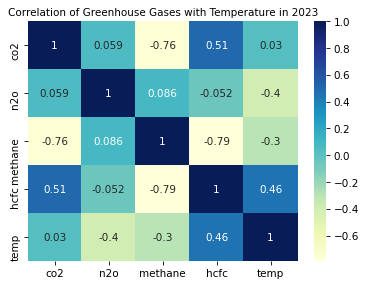

In [103]:
# Plotting the correlation matrix for the Greenhouse Gases with Temperature

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2023", fontsize=10)
plt.show()

### Conclusion ###
In this project, we:

Forecasted the temperature of a given city over a given period of time
Predicted the top-10 cities in the US which will experience the most temperature change from 2013-2013.
Analyzed the correlation between pollution levels and temperature, as well as the correlation between Greenhouse gas emissions and temperature, which helped us identify the Greenhouse Gas that has and will have the most impact on temperature change.